<a href="https://colab.research.google.com/github/faiyaz106/Thermal-facial-landmark-detection/blob/main/train_unet_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Jun 10 01:11:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Loading the data from google drive (By mounting google drive )
from google.colab import drive

drive.mount("/thermal")

Mounted at /thermal


In [3]:
# import the necessary packages

from imutils import paths
import imutils
import json
import time
import cv2
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import AveragePooling2D

from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

### Loading SpeakingFaces dataset

In [4]:
# function to correct landmarks' order after mirroring

def correct_landmarks_order(pts_mirr):
    # pts_mirr - list of landmarks for one face
    
	pts_mirr_c = []
    
	# chin
	pts_mirr_c.append(pts_mirr[16])
	pts_mirr_c.append(pts_mirr[15])
	pts_mirr_c.append(pts_mirr[14])
	pts_mirr_c.append(pts_mirr[13])
	pts_mirr_c.append(pts_mirr[12])
	pts_mirr_c.append(pts_mirr[11])
	pts_mirr_c.append(pts_mirr[10])
	pts_mirr_c.append(pts_mirr[9])
	pts_mirr_c.append(pts_mirr[8])
	pts_mirr_c.append(pts_mirr[7])
	pts_mirr_c.append(pts_mirr[6])
	pts_mirr_c.append(pts_mirr[5])
	pts_mirr_c.append(pts_mirr[4])
	pts_mirr_c.append(pts_mirr[3])
	pts_mirr_c.append(pts_mirr[2])
	pts_mirr_c.append(pts_mirr[1])
	pts_mirr_c.append(pts_mirr[0])

	# left eyebrow
	pts_mirr_c.append(pts_mirr[26])
	pts_mirr_c.append(pts_mirr[25])
	pts_mirr_c.append(pts_mirr[24])
	pts_mirr_c.append(pts_mirr[23])
	pts_mirr_c.append(pts_mirr[22])

	# right eyebrow
	pts_mirr_c.append(pts_mirr[21])
	pts_mirr_c.append(pts_mirr[20])
	pts_mirr_c.append(pts_mirr[19])
	pts_mirr_c.append(pts_mirr[18])
	pts_mirr_c.append(pts_mirr[17])

	# nose bridge
	pts_mirr_c.append(pts_mirr[27])
	pts_mirr_c.append(pts_mirr[28])
	pts_mirr_c.append(pts_mirr[29])
	pts_mirr_c.append(pts_mirr[30])

	# nose tip
	pts_mirr_c.append(pts_mirr[35])
	pts_mirr_c.append(pts_mirr[34])
	pts_mirr_c.append(pts_mirr[33])
	pts_mirr_c.append(pts_mirr[32])
	pts_mirr_c.append(pts_mirr[31])

	# left eye
	pts_mirr_c.append(pts_mirr[45])
	pts_mirr_c.append(pts_mirr[44])
	pts_mirr_c.append(pts_mirr[43])
	pts_mirr_c.append(pts_mirr[42])
	pts_mirr_c.append(pts_mirr[47])
	pts_mirr_c.append(pts_mirr[46])

	# right eye
	pts_mirr_c.append(pts_mirr[39])
	pts_mirr_c.append(pts_mirr[38])
	pts_mirr_c.append(pts_mirr[37])
	pts_mirr_c.append(pts_mirr[36])
	pts_mirr_c.append(pts_mirr[41])
	pts_mirr_c.append(pts_mirr[40])

	# lips 
	pts_mirr_c.append(pts_mirr[50])
	pts_mirr_c.append(pts_mirr[49])
	pts_mirr_c.append(pts_mirr[48])
	pts_mirr_c.append(pts_mirr[51])
	pts_mirr_c.append(pts_mirr[52])
	pts_mirr_c.append(pts_mirr[53])

	return pts_mirr_c

In [5]:
# path to the dataset
datasetPath = '/thermal/MyDrive/dataset'

# original image size and intended image size
H = 512
W = 640

h = 256
w = 256

# number of facial landmarks
KEYPOINTS = 54

In [6]:
# function to import dataset
def import_data(t):
    # s - train / val / test
    # t- gray/iron
    # list to store imported data
    images = []
    annotations =[]
    masks =[]
    # extract paths to json files
    # we use grayscaled images for landmark prediction
    #jsonFolder = os.path.join(datasetPath, "gray", s, 'json')
    #jsonPaths = list(paths.list_files(jsonFolder, validExts="json"))
    #jsonPaths = sorted(jsonPaths)
    labelsFolder='/thermal/MyDrive/dataset/labels/'
    txtPaths = list(paths.list_files(labelsFolder, validExts="txt"))
    txtPaths = sorted(txtPaths)

    # loop over the json files
    for ind, txtPath in enumerate(txtPaths, 1):
      
        print("[INFO] Processing {} file ({}/{})".format(txtPath.split("/")[-1], ind, len(txtPaths)))
        
        # opening the text file 
        f = open(txtPath,) 
        f=f.readlines()
    
        # loading the image and converting it to grayscale
        imagePath = txtPath.replace('labels',t)
        imagePath = imagePath.replace('.txt', '.jpg')
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
        # loading and processing the mask
        maskPath =imagePath = imagePath.replace(t,'masks')
        maskPath =imagePath = imagePath.replace('.jpg','.png')
        mask = cv2.imread(maskPath)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask.astype('float32')
        mask = mask / 255.0
        
        # mirrored mask
        mask_mirr = cv2.flip(mask, flipCode=1)
      
        # iterating through the shapes
        landmarks = []
        # resize the image, normalize
        crop_image = cv2.resize(image, (w, h) )
        crop_image = crop_image.astype('float32')
        crop_image = crop_image / 255.0
              
        # mirror the processed image
        crop_image_flip = cv2.flip(crop_image, flipCode=1)
        
        for point in f:
            point=point.split(' ')
            x=point[1]
            y=point[2]
            (x,y)=(float(x),float(y))
            (x_re,y_re)=(x, y)
            landmarks.append([y_re,x_re])
        landmarks = np.array(landmarks)
        # mirror the landmarks
        landmarks_mirr = landmarks.copy()
        landmarks_mirr[:,1] = 1 - landmarks_mirr[:,1]
        landmarks_mirr = correct_landmarks_order(landmarks_mirr.tolist())
      
        # flatten the landmarks
        landmarks = landmarks.flatten()
        landmarks_mirr = np.array(landmarks_mirr).flatten()

        # store imported and processed data
        images.append(crop_image)    
        annotations.append(landmarks)
        masks.append(mask)
        
        images.append(crop_image_flip)    
        annotations.append(landmarks_mirr)
        masks.append(mask_mirr)

    
    # converting to numpy arrays
    # expanding image dimensions from (N, h, w) to (N, h, w, 1)
    images = np.expand_dims(np.array(images), axis = 3)
    masks = np.expand_dims(np.array(masks), axis = 3)
    
    annotations = np.array(annotations)
    
    return images, masks, annotations

In [ ]:
img_train, bmask_train, l_train = import_data('gray')

[INFO] Processing 1_11178.txt file (1/100)
[INFO] Processing 1_11732.txt file (2/100)
[INFO] Processing 1_12043.txt file (3/100)
[INFO] Processing 1_12260.txt file (4/100)
[INFO] Processing 1_12600.txt file (5/100)
[INFO] Processing 1_12929.txt file (6/100)
[INFO] Processing 1_13014.txt file (7/100)
[INFO] Processing 1_14762.txt file (8/100)
[INFO] Processing 1_16230.txt file (9/100)
[INFO] Processing 1_16323.txt file (10/100)
[INFO] Processing 1_17866.txt file (11/100)
[INFO] Processing 1_17981.txt file (12/100)
[INFO] Processing 1_19078.txt file (13/100)
[INFO] Processing 1_19787.txt file (14/100)
[INFO] Processing 1_19801.txt file (15/100)
[INFO] Processing 1_19961.txt file (16/100)
[INFO] Processing 1_20066.txt file (17/100)
[INFO] Processing 1_20474.txt file (18/100)
[INFO] Processing 1_20498.txt file (19/100)
[INFO] Processing 1_20623.txt file (20/100)
[INFO] Processing 1_20961.txt file (21/100)
[INFO] Processing 1_23373.txt file (22/100)
[INFO] Processing 1_23528.txt file (23/10

In [ ]:
# sanity check
print(img_train.shape)
print(l_train.shape)
print(bmask_train.shape)


(200, 256, 256, 1)
(200, 108)
(200, 256, 256, 1)


In [ ]:
# visualize to check if images were correctly uploaded

def visualize(image, landmarks, mask):

    fig, axs = plt.subplots(1, 2, figsize=(10,5))

    axs[0].imshow(image[:,:,0], cmap='gray')
    axs[1].imshow(mask[:,:,0], cmap='gray')
    
    keys = landmarks.copy().reshape(KEYPOINTS,2)
    
    axs[0].plot(keys[:,1]*w, keys[:,0]*h, 'gD', markersize=3)

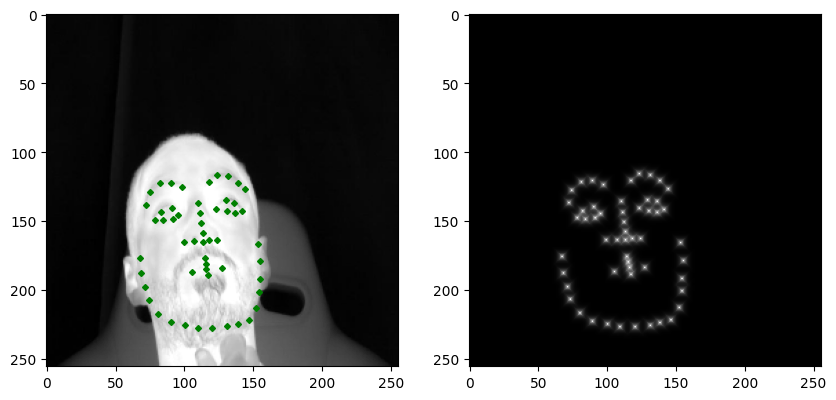

In [ ]:
i = 50
visualize(img_train[i], l_train[i], bmask_train[i])

### Model

In [ ]:
input_size = (h, w, 1)
inputs = keras.Input(input_size)

# downsampling

conv1 = Conv2D(64, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(inputs)
conv1 = Conv2D(64, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(conv1)

pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(128, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(pool1)
conv2 = Conv2D(128, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(conv2)

pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(256, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(pool2)
conv3 = Conv2D(256, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(conv3)

pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(512, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(pool3)
conv4 = Conv2D(512, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(conv4)

pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
conv5 = Conv2D(1024, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(pool4)
conv5 = Conv2D(1024, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(conv5)

drop5 = Dropout(0.5)(conv5)

# upsampling

up6 = Conv2DTranspose(512, 3, strides = (2,2), activation='relu', padding = 'same', kernel_initializer='glorot_normal') (drop5)
merge6 = concatenate([conv4,up6], axis = 3)
conv6 = Conv2D(512, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(merge6)
conv6 = Conv2D(512, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(conv6)

up7 = Conv2DTranspose(256, 3, strides = (2,2), activation='relu', padding = 'same', kernel_initializer='glorot_normal') (conv6)
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(merge7)
conv7 = Conv2D(256, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(conv7)

up8 = Conv2DTranspose(128, 3, strides = (2,2), activation='relu', padding = 'same', kernel_initializer='glorot_normal') (conv7)
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(128, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(merge8)
conv8 = Conv2D(128, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(conv8)

up9 = Conv2DTranspose(64, 3, strides = (2,2), activation='relu', padding = 'same', kernel_initializer='glorot_normal') (conv8)
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(merge9)
conv9 = Conv2D(64, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(conv9)

drop9 = Dropout(0.5)(conv9)

conv10 = Conv2D(1, 1, activation = 'sigmoid', padding = 'same', kernel_initializer='glorot_normal')(drop9)

u_net = keras.Model(inputs = inputs, outputs = conv10)

In [ ]:
u_net.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

### First Stage: Pre-Training

In [ ]:
# create checkpoint
checkpoint_dir = "checkpoints-sf-0-1"
callback_checkpoint = keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir+"/landmark", 
                                                      save_weights_only=True, 
                                                      save_best_only=True,monitor='val_loss',
                                                      verbose=1)

# initializing callback function
callbacks0 = [callback_checkpoint]

if not tf.io.gfile.exists(checkpoint_dir):
    tf.io.gfile.mkdir(checkpoint_dir)
    print("Checkpoint directory created: {}".format(checkpoint_dir))

# if checkpoint exists, load the weights
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

if latest_checkpoint:
    print("Checkpoint found: {}, restoring...".format(latest_checkpoint))
    u_net.load_weights(latest_checkpoint)
    print("Checkpoint restored: {}".format(latest_checkpoint))
else:
    print("Checkpoint not found. Model weights will be initialized randomly.")

Checkpoint directory created: checkpoints-sf-0-1
Checkpoint not found. Model weights will be initialized randomly.


In [ ]:
# learning rate scheduler

def lr_schedule( epoch ):

    lr = 5e-4
    
    if epoch >= 10:
        lr = 1e-4

    print("Learning rate: ", lr)
    return lr

In [ ]:
# setting learning rate scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)

# setting early stopping 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callbacks0.append(lr_scheduler)
callbacks0.append(es)

In [ ]:
# compile
u_net.compile(loss='binary_crossentropy', optimizer = keras.optimizers.Adam(lr_schedule(0)))

In [ ]:
# train
history = u_net.fit(img_train, bmask_train, shuffle=True, batch_size=32, epochs=20, callbacks=callbacks0)

Learning rate:  0.0005
Epoch 1/20
7/7 [==============================] - ETA: 0s - loss: 0.6236

7/7 [==============================] - 84s 4s/step - loss: 0.6236 - lr: 5.0000e-04
Learning rate:  0.0005
Epoch 2/20
7/7 [==============================] - ETA: 0s - loss: 0.3972

7/7 [==============================] - 12s 2s/step - loss: 0.3972 - lr: 5.0000e-04
Learning rate:  0.0005
Epoch 3/20
7/7 [==============================] - ETA: 0s - loss: 0.2228

7/7 [==============================] - 12s 2s/step - loss: 0.2228 - lr: 5.0000e-04
Learning rate:  0.0005
Epoch 4/20
7/7 [==============================] - ETA: 0s - loss: 0.0942

7/7 [==============================] - 13s 2s/step - loss: 0.0942 - lr: 5.0000e-04
Learning rate:  0.0005
Epoch 5/20
7/7 [==============================] - ETA: 0s - loss: 0.0603

7/7 [==============================] - 12s 2s/step - loss: 0.0603 - lr: 5.0000e-04
Learning rate:  0.0005
Epoch 6/20
7/7 [==============================] - ETA: 0s - loss: 0.0588

7/7 [==============================] - 12s 2s/step - loss: 0.0588 - lr: 5.0000e-04
Learning rate:  0.0005
Epoch 7/20
7/7 [==============================] - ETA: 0s - loss: 0.0574

7/7 [==============================] - 12s 2s/step - loss: 0.0574 - lr: 5.0000e-04
Learning rate:  0.0005
Epoch 8/20
7/7 [==============================] - ETA: 0s - loss: 0.0560

7/7 [==============================] - 12s 2s/step - loss: 0.0560 - lr: 5.0000e-04
Learning rate:  0.0005
Epoch 9/20
7/7 [==============================] - ETA: 0s - loss: 0.0554

7/7 [==============================] - 12s 2s/step - loss: 0.0554 - lr: 5.0000e-04
Learning rate:  0.0005
Epoch 10/20
7/7 [==============================] - ETA: 0s - loss: 0.0544

7/7 [==============================] - 12s 2s/step - loss: 0.0544 - lr: 5.0000e-04
Learning rate:  0.0001
Epoch 11/20
7/7 [==============================] - ETA: 0s - loss: 0.0538

7/7 [==============================] - 12s 2s/step - loss: 0.0538 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 12/20
7/7 [==============================] - ETA: 0s - loss: 0.0533

7/7 [==============================] - 12s 2s/step - loss: 0.0533 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 13/20
7/7 [==============================] - ETA: 0s - loss: 0.0530

7/7 [==============================] - 12s 2s/step - loss: 0.0530 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 14/20
7/7 [==============================] - ETA: 0s - loss: 0.0526

7/7 [==============================] - 12s 2s/step - loss: 0.0526 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 15/20
7/7 [==============================] - ETA: 0s - loss: 0.0524

7/7 [==============================] - 12s 2s/step - loss: 0.0524 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 16/20
7/7 [==============================] - ETA: 0s - loss: 0.0519

7/7 [==============================] - 12s 2s/step - loss: 0.0519 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 17/20
7/7 [==============================] - ETA: 0s - loss: 0.0515

7/7 [==============================] - 12s 2s/step - loss: 0.0515 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 18/20
7/7 [==============================] - ETA: 0s - loss: 0.0509

7/7 [==============================] - 12s 2s/step - loss: 0.0509 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 19/20
7/7 [==============================] - ETA: 0s - loss: 0.0504

7/7 [==============================] - 12s 2s/step - loss: 0.0504 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 20/20
7/7 [==============================] - ETA: 0s - loss: 0.0501

7/7 [==============================] - 12s 2s/step - loss: 0.0501 - lr: 1.0000e-04


KeyError: ignored

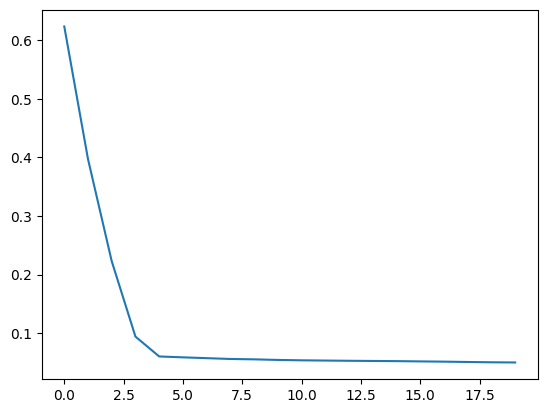

In [ ]:
# plot loss vs epochs curve

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('# epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# visualizing predicted mask
    
def visualize_mask_prediction(ind, images, masks_gt):

    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    
    # predict mask on one image
    img = images[ind].copy()
    img = np.expand_dims(img, axis = 0)    
    mask_pr = u_net.predict(img)

    # plot
    axs[0].imshow(img[0, :,:,0], cmap = 'gray')           # image
    axs[1].imshow(masks_gt[ind, :,:,0], cmap = 'gray')    # ground truth mask
    axs[2].imshow(mask_pr[0, :,:,0], cmap = 'gray')       # predicted mask
    
    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')

1/1 [==============================] - 2s 2s/step


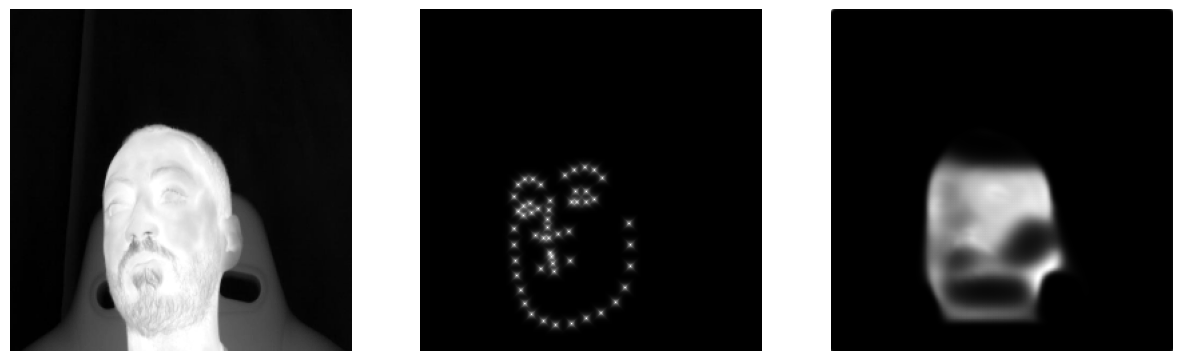

In [ ]:
visualize_mask_prediction(42, img_train, bmask_train)

1/1 [==============================] - 0s 36ms/step


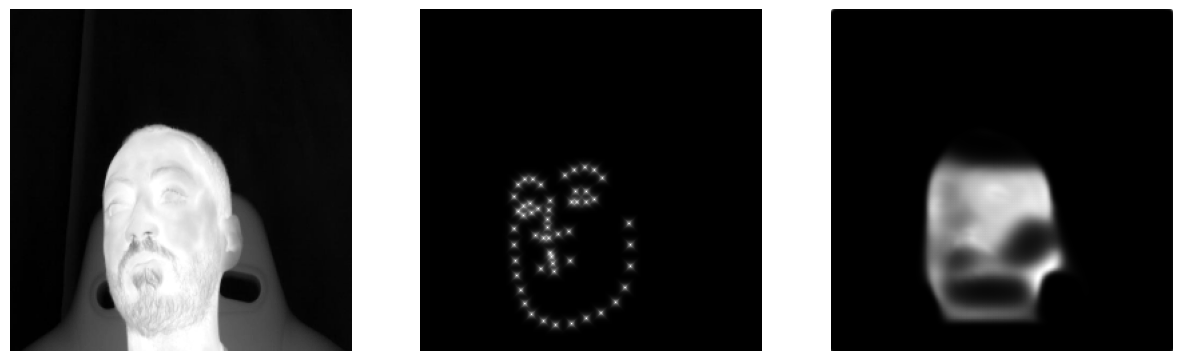

In [ ]:
visualize_mask_prediction(42, img_train, bmask_train)

### Second Stage: Pre-Training

In [ ]:
# fully connected layers
avg_pooling = AveragePooling2D(pool_size=(7, 7))(u_net.output)
flat = Flatten() (avg_pooling)
fc0 = Dense(2048, activation = 'relu') (flat)
dropout0 = Dropout(0.3)(fc0)
fc1 = Dense(512, activation = 'relu') (dropout0)
dropout1 = Dropout(0.3)(fc1)
fc2  = Dense(108, activation = 'sigmoid') (dropout1)

# define full model
model_full = keras.Model(inputs=u_net.input, outputs=fc2)

# freeze U-net layers
u_net.trainable = False

In [ ]:
# to check whether layers are trainable or not

for i,layer in enumerate(model_full.layers):
    print(i,layer.name,layer.trainable)

0 input_1 False
1 conv2d False
2 conv2d_1 False
3 max_pooling2d False
4 conv2d_2 False
5 conv2d_3 False
6 max_pooling2d_1 False
7 conv2d_4 False
8 conv2d_5 False
9 max_pooling2d_2 False
10 conv2d_6 False
11 conv2d_7 False
12 max_pooling2d_3 False
13 conv2d_8 False
14 conv2d_9 False
15 dropout False
16 conv2d_transpose False
17 concatenate False
18 conv2d_10 False
19 conv2d_11 False
20 conv2d_transpose_1 False
21 concatenate_1 False
22 conv2d_12 False
23 conv2d_13 False
24 conv2d_transpose_2 False
25 concatenate_2 False
26 conv2d_14 False
27 conv2d_15 False
28 conv2d_transpose_3 False
29 concatenate_3 False
30 conv2d_16 False
31 conv2d_17 False
32 dropout_1 False
33 conv2d_18 False
34 average_pooling2d True
35 flatten True
36 dense True
37 dropout_2 True
38 dense_1 True
39 dropout_3 True
40 dense_2 True


In [ ]:
# Wing loss

def wing_loss(land_gt, land_pred, w=10.0, epsilon=2.0):

    with tf.name_scope('wing_loss'):
        
        # compute constant C
        C = w * (1.0 - math.log(1.0 + w / epsilon))
        
        x = land_gt - land_pred
        abs_x = tf.abs(x)
        
        # if absolute x is smaller than w, then first equation
        # otherwise, second
        losses = tf.where(tf.greater(w, abs_x), w * tf.math.log(1.0 + abs_x / epsilon), abs_x - C)        
        loss = tf.reduce_mean(losses)
        
        return loss

In [ ]:
# create checkpoint
checkpoint_dir = "checkpoints-sf-0-2"

callback_checkpoint = keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir+"/landmark", 
                                                      save_weights_only=True, 
                                                      save_best_only=True,monitor='val_loss',
                                                      verbose=1)

# initializing callback function
callbacks1 = [callback_checkpoint]

if not tf.io.gfile.exists(checkpoint_dir):
    tf.io.gfile.mkdir(checkpoint_dir)
    print("Checkpoint directory created: {}".format(checkpoint_dir))
    
# if checkpoint exists, load the weights
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    print("Checkpoint found: {}, restoring...".format(latest_checkpoint))
    u_net.load_weights(latest_checkpoint)
    print("Checkpoint restored: {}".format(latest_checkpoint))
else:
    print("Checkpoint not found. Model weights will be initialized randomly.")


Checkpoint directory created: checkpoints-sf-0-2
Checkpoint not found. Model weights will be initialized randomly.


In [ ]:
# learning rate scheduler
def lr_schedule( epoch ):

    lr = 1e-3
    
    if epoch >= 20:
        lr = 1e-4

    print("Learning rate: ", lr)
    return lr

In [ ]:
# setting learning rate scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)

# setting early stopping 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callbacks1.append(lr_scheduler)
callbacks1.append(es)

In [ ]:
# compile
model_full.compile(optimizer = keras.optimizers.Adam(lr_schedule(0)), loss=wing_loss)

In [ ]:
# train
history2 = model_full.fit(img_train, l_train, validation_data=(img_val, l_val), batch_size=16, shuffle=True, epochs=40, callbacks=callbacks1)

NameError: ignored

In [ ]:
# plot loss vs epochs curve

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('# epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# visualize prediction on single image

def visualize_pred(ind, images, landmarks):
    
    plt.figure(figsize=(5,5))
    
    # load an image    
    img = images[ind].copy()
    img = np.expand_dims(img, axis = 0)
    plt.imshow(img[0][:,:,0], cmap='gray')
    
    land_pred = model_full.predict(img)    

    # ground truth landmarks
    keypoints = landmarks[ind].copy().reshape(KEYPOINTS,2)
    keypoints[:,0] = keypoints[:,0] * h
    keypoints[:,1] = keypoints[:,1] * w
    plt.plot(keypoints[:,1], keypoints[:,0], 'go', markersize=3)
    
    # predicted landmarks
    keypointsT = land_pred[0].copy().reshape(KEYPOINTS,2)
    keypointsT[:,0] = keypointsT[:,0] * h
    keypointsT[:,1] = keypointsT[:,1] * w
    plt.plot(keypointsT[:,1], keypointsT[:,0], 'ro', markersize=3)    
    
    plt.axis('off')

In [ ]:
visualize_pred(42, img_train, l_train)

In [ ]:
visualize_pred(42, img_test, l_test)

In [ ]:
# visualize prediction on random ten images

def visualize_pred_rand(images, landmarks, gt=True):

    fig, axs = plt.subplots(2, 5, figsize=(15,6))    
    plt.subplots_adjust(wspace=0, hspace=0.1)
    
    # selecting 10 random images from set
    indexes = np.random.randint(0,images.shape[0],10)
    img = images[indexes]
    land = landmarks[indexes]
    land_pred = model_full.predict(img)
    
    # iterate over images
    ind = 0
    
    for i in range(2):
        for j in range(5):
            
            # display image
            axs[i, j].imshow(img[ind][:,:,0], cmap='gray')
            
            # display predicted landmarks
            keypointsT = land_pred[ind].copy().reshape(KEYPOINTS,2)
            keypointsT[:,0] = keypointsT[:,0] * h
            keypointsT[:,1] = keypointsT[:,1] * w

            axs[i, j].plot(keypointsT[:,1], keypointsT[:,0], 'ro', markersize=2)
            
            # if gt is true, display ground truth landmarks
            if gt:
                keypoints = land[ind].copy().reshape(KEYPOINTS,2)
                keypoints[:,0] = keypoints[:,0] * h
                keypoints[:,1] = keypoints[:,1] * w           
                axs[i, j].plot(keypoints[:,1], keypoints[:,0], 'go', markersize=2)

            # turn off axis display
            axs[i, j].axis('off')
            
            ind += 1
    
    # save figure
    plt.savefig("results.png")

In [ ]:
visualize_pred_rand(img_test, l_test)

In [ ]:
# normalized mean error

def NME(land, land_pred):
    
    N = land.shape[0]    
    l = land.reshape(land.shape[:-1] + (KEYPOINTS,2))
    lt = land_pred.reshape(land_pred.shape[:-1] + (KEYPOINTS,2))
    
    # error for one sample
    nme = (np.sum(np.sqrt(np.sum((l - lt)**2, axis=2)), axis=1)
                            / np.sqrt(np.sum((l[:,45] - l[:,36])**2, axis=1))) / KEYPOINTS
        
    # average over the whole sample
    nme_avg = np.sum(nme) / N
    
    return nme_avg

In [ ]:
# predicting landmarks
l_test_pred = model_full.predict(img_test)
l_train_pred = model_full.predict(img_train)
l_val_pred = model_full.predict(img_val)

# evaluating NME of predictions
print("Normalized Mean Error on training set: ", NME(l_train, l_train_pred))
print("Normalized Mean Error on validation set: ", NME(l_val, l_val_pred))
print("Normalized Mean Error on testing set: ", NME(l_test, l_test_pred))

### Third Stage: Full Training

In [ ]:
# unfreezing the U-net layers
u_net.trainable = True

for i,layer in enumerate(model_full.layers):
    print(i,layer.name,layer.trainable)

0 input_1 True
1 conv2d True
2 conv2d_1 True
3 max_pooling2d True
4 conv2d_2 True
5 conv2d_3 True
6 max_pooling2d_1 True
7 conv2d_4 True
8 conv2d_5 True
9 max_pooling2d_2 True
10 conv2d_6 True
11 conv2d_7 True
12 max_pooling2d_3 True
13 conv2d_8 True
14 conv2d_9 True
15 dropout True
16 conv2d_transpose True
17 concatenate True
18 conv2d_10 True
19 conv2d_11 True
20 conv2d_transpose_1 True
21 concatenate_1 True
22 conv2d_12 True
23 conv2d_13 True
24 conv2d_transpose_2 True
25 concatenate_2 True
26 conv2d_14 True
27 conv2d_15 True
28 conv2d_transpose_3 True
29 concatenate_3 True
30 conv2d_16 True
31 conv2d_17 True
32 dropout_1 True
33 conv2d_18 True
34 average_pooling2d True
35 flatten True
36 dense True
37 dropout_2 True
38 dense_1 True
39 dropout_3 True
40 dense_2 True


In [ ]:
# create checkpoint
checkpoint_dir = "checkpoints-sf-0-3"

callback_checkpoint = keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir+"/landmark", 
                                                      save_weights_only=True, 
                                                      save_best_only=True,monitor='val_loss',
                                                      verbose=1)

# initializing callback function
callbacks2 = [callback_checkpoint]

if not tf.io.gfile.exists(checkpoint_dir):
    tf.io.gfile.mkdir(checkpoint_dir)
    print("Checkpoint directory created: {}".format(checkpoint_dir))

# if checkpoint exists, load the weights
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

if latest_checkpoint:
    print("Checkpoint found: {}, restoring...".format(latest_checkpoint))
    model_full.load_weights(latest_checkpoint)
    print("Checkpoint restored: {}".format(latest_checkpoint))
else:
    print("Checkpoint not found. Model weights will be initialized randomly.")

Checkpoint found: checkpoints-sf-0-3/landmark, restoring...
Checkpoint restored: checkpoints-sf-0-3/landmark


In [ ]:
# learning rate scheduler

def lr_schedule( epoch ):

    lr = 1e-4

    print("Learning rate: ", lr)
    return lr

In [ ]:
# setting learning rate scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)

# setting early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callbacks2.append(lr_scheduler)
callbacks2.append(es)

In [ ]:
# compile
model_full.compile(optimizer = keras.optimizers.Adam(lr_schedule(0)), loss=wing_loss)

Learning rate:  0.0001


In [ ]:
# train
history3 = model_full.fit(img_train, l_train, validation_data=(img_val, l_val), batch_size=16, shuffle=True, epochs=20, callbacks=callbacks2)

Train on 3558 samples, validate on 360 samples
Learning rate:  0.0001
Epoch 1/20
3552/3558 [============================>.] - ETA: 0s - loss: 0.0678
Epoch 00001: val_loss improved from inf to 0.05701, saving model to checkpoints-sf-1-3/landmark
3558/3558 [==============================] - 64s 18ms/sample - loss: 0.0678 - val_loss: 0.0570
Learning rate:  0.0001
Epoch 2/20
3552/3558 [============================>.] - ETA: 0s - loss: 0.0683
Epoch 00002: val_loss did not improve from 0.05701
3558/3558 [==============================] - 60s 17ms/sample - loss: 0.0682 - val_loss: 0.0582
Learning rate:  0.0001
Epoch 3/20
3552/3558 [============================>.] - ETA: 0s - loss: 0.0681
Epoch 00003: val_loss improved from 0.05701 to 0.05691, saving model to checkpoints-sf-1-3/landmark
3558/3558 [==============================] - 61s 17ms/sample - loss: 0.0681 - val_loss: 0.0569
Learning rate:  0.0001
Epoch 4/20
3552/3558 [============================>.] - ETA: 0s - loss: 0.0676
Epoch 00004: 

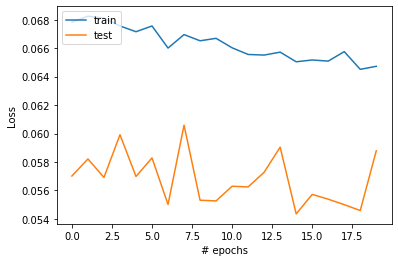

In [ ]:
# plot loss vs epochs curve

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('# epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# load best weights from checkpoint

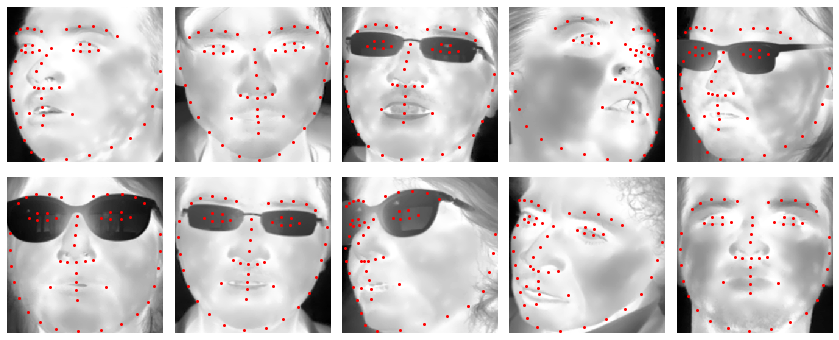

In [ ]:
# visualize ten random predictions from test set

visualize_pred_rand(img_test, l_test, False)

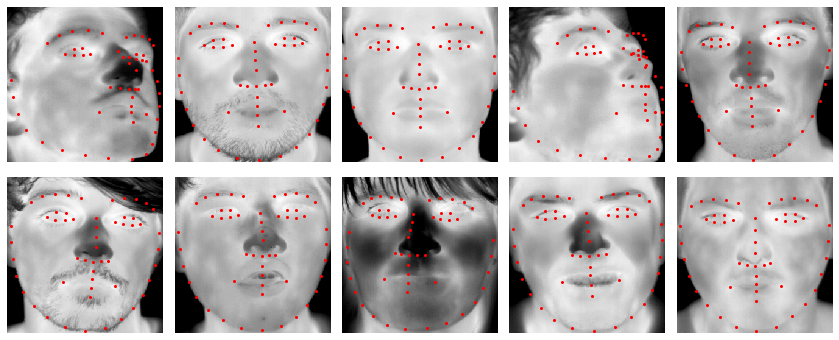

In [ ]:
# visualize ten random predictions from RWTH-Aachen set

visualize_pred_rand(img_aachen, l_aachen, False)

In [ ]:
# calculate Mean Absolute Error

def MAE(l, l_pred):
    
    mae = keras.losses.mean_absolute_error(l, l_pred)
    
    return np.mean(tf.Session().run(mae))

In [ ]:
# calculate average time needed to predict landmarks on an image

def inference_speed(images):
    
    timings = []
    
    # iterate over images
    for img in images:
        
        img = np.expand_dims(img, axis = 0)
        
        # record time
        start = time.time()
        preds = model_full.predict(img)
        end = time.time() 

        timings.append(end - start)
    
    return np.average(timings)

In [ ]:
# predicting landmarks
l_train_pred = model_full.predict(img_train)
l_val_pred = model_full.predict(img_val)
l_test_pred = model_full.predict(img_test)
l_test_aa_pred = model_full.predict(img_aachen)

In [ ]:
# evaluating NME of predictions
print("Normalized Mean Error on training set: ", NME(l_train, l_train_pred))
print("Normalized Mean Error on validation set: ", NME(l_val, l_val_pred))
print("Normalized Mean Error on testing set: ", NME(l_test, l_test_pred))
print("Normalized Mean Error on RWTH-Aachen: ", NME(l_aachen, l_test_aa_pred))
      
# evaluating MAE of predictions
print("\nMean Absolute Error on training set: ", MAE(l_train, l_train_pred))
print("Mean Absolute Error on validation set: ", MAE(l_val, l_val_pred))
print("Mean Absolute Error on testing set: ", MAE(l_test, l_test_pred))
print("Mean Absolute Error on RWTH-Aachen: ", MAE(l_aachen, l_test_aa_pred))

Normalized Mean Error on training set:  0.027968576554859997
Normalized Mean Error on validation set:  0.033306293793537625
Normalized Mean Error on testing set:  0.03562876961097509
Normalized Mean Error on RWTH-Aachen:  0.058695503525919825

Mean Absolute Error on training set:  0.009228825
Mean Absolute Error on validation set:  0.0110948
Mean Absolute Error on testing set:  0.011755808
Mean Absolute Error on RWTH-Aachen:  0.022014903


In [ ]:
# inference speed

print("Inference speed (average per image): ", inference_speed(img_test))

Inference speed (average per image):  0.011249885275647357


In [ ]:
# save weights

model_full.save('model.h5')
print("Model size (KB): ", os.path.getsize('model.h5')/1000)

Model size (KB):  153208.304
